In [1]:
#https://unc.bootcampcontent.com/UNC-Coding-Boot-Camp/UNC-RAL-DATA-PT-11-2019-U-C/tree/master/02-Homework/10-Advanced-Data-Storage-and-Retrieval/Instructions

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

In [4]:
# Reflect Tables into SQLAlchemy ORM
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station 

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
print(f'Measurements tables')
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
print()
print("stations tables")
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

Measurements tables
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

stations tables
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Exploratory Climate Analysis
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = dt.date(2017,8, 23) - dt.timedelta(days = 365)
last_date
# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_date)
data

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(data, columns=['date','prcp'])
prcp_df.head()
# Sort the dataframe by date
prcp_df = prcp_df.set_index('date')

prcp_df = prcp_df.sort_index()
prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data 
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


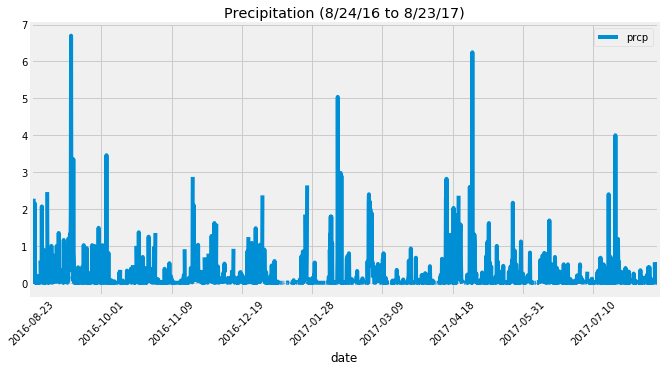

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(rot=45, figsize=(10,5))
ax.set_title("Precipitation (8/24/16 to 8/23/17)")
plt.show()

In [16]:
# Design a query to show how many stations are available in this dataset.
station_count = session.query(func.count(Station.station)).all()
station_count

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_list = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                             order_by(func.count(Measurement.station).desc()).all()
station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station.
data_most_active_station = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').order_by(func.min(Measurement.tobs)).all()
data_most_active_station

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
station_most_temps = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
station_most_temps

('USC00519281', 2772)

In [19]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps_519281 = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').\
    filter(Measurement.date >= last_date).order_by(Measurement.date.desc()).all()
temps_519281_df = pd.DataFrame(temps_519281, columns=['Temperature (F)'])
temps_519281_df.head()

,Temperature (F)
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


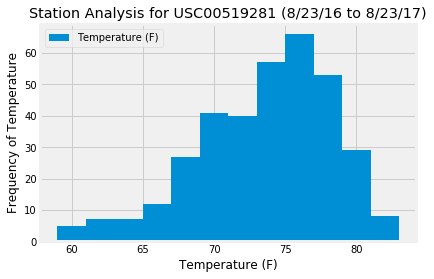

In [20]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temps_519281_df["Temperature (F)"], bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency of Temperature")
plt.title("Station Analysis for USC00519281 (8/23/16 to 8/23/17)")
plt.legend(["Temperature (F)"])
plt.savefig("output/FrequencyofTemps.png")
plt.show()

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_yr_start_date = dt.date(2018,1,1) - dt.timedelta(days= 365)
prev_yr_end_date = prev_yr_start_date + dt.timedelta(days = 5)
calc_temp = calc_temps(prev_yr_start_date,prev_yr_end_date)
print(calc_temp)

[(62.0, 68.05714285714286, 74.0)]


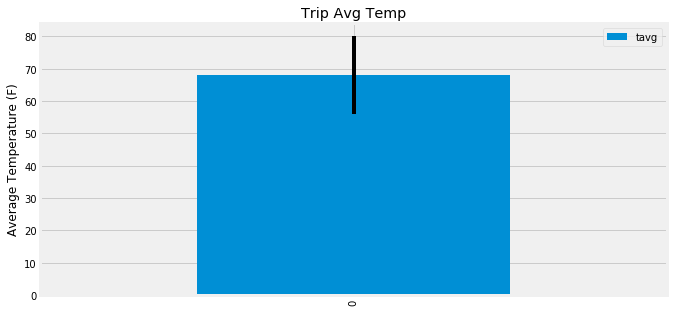

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
calc_temp_df = pd.DataFrame(calc_temp, columns=['tmin', 'tavg', 'tmax'])
calc_temp_df

calc_temp_df.plot.bar(y='tavg', yerr=(calc_temp_df['tmax'] - calc_temp_df['tmin']), title='Trip Avg Temp', figsize=(10,5))
plt.ylabel("Average Temperature (F)")
plt.savefig("output/TripAvgTemp.png")
plt.show()

In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prcp_all = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= prev_yr_start_date, Measurement.date <= prev_yr_end_date).\
        filter(Measurement.station == Station.station).\
        group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
prcp_all

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.61),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.6),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.2),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]